In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import integrate
from scipy.integrate import ode
from scipy.integrate import quad
from scipy.integrate import trapz
%matplotlib inline

In [2]:
Vm = 105*1.414   #Phase peak voltage                 
freq = 400
w=2*np.pi *freq    
J = 0.0001675       #moment of inertia
T_l = 1          #load torque
B=0 #0.006      #coefficient of friction 
P=4          #no of poles
Rs=.047/3    #stator resistance
Rr=.05/3     #rotor resistance
Lm=8.71/w/3  #mutual inductance
Lls=.433/w/3 #stator leakage inductance
Llr=.623/w/3
Ls=Lm + Lls   #stator inductance
Lr=Lm + Llr   # rotor inductance

R=([Rs,0,0,0],[0,Rs,0,0],[0,0,Rr,0],[0,0,0,Rr])      
L=([Ls,0,Lm,0],[0,Ls,0,Lm],[Lm,0,Lr,0],[0,Lm,0,Lr])
G=([0,0,0,0],[0,0,0,0],[0,Lm,0,Lr],[-Lm,0,-Lr,0])
invL=np.linalg.inv(L)

vdq=np.zeros((2,1))
v=np.zeros((4,1))
i=np.zeros((4,1))
di_dt=np.zeros((4,1))

torque, i_as, i_bs, i_cs ,speed,t = ([] for i in range(6))

s0 = [0, 0, 0, 0, 0]
t0 = 0
t_end = 2
dt = 0.0001

In [3]:
def dxdt(t, x):
    
    i_ds, i_qs, i_dr, i_qr, w_r = x[0], x[1], x[2], x[3], x[4]
    
    c = ([1,-.5,-.5],[0,.866,-.866])
    vdq = ((2./3)*Vm)*np.dot(c ,([np.sin(w*t)],
                                 [np.sin(w*t -(2./3)*np.pi)],
                                 [np.sin(w*t + (2./3)*np.pi)]))
    
    v[0], v[1] = vdq[0], vdq[1]
    i[0], i[1], i[2], i[3] = i_ds, i_qs, i_dr, i_qr
   
    di_dt = np.dot(invL ,(v-(np.dot(R,i) + w_r*np.dot(G,i))))
    dids_dt, diqs_dt, didr_dt, diqr_dt = di_dt[0], di_dt[1], di_dt[2], di_dt[3]

    Te = (3*Lm*((i[2] * i[1]) -(i[3] *i[0])))

    dwr_dt = (Te - T_l )*P/(2*J) + (-(B/J))*w_r 
    return [dids_dt, diqs_dt, didr_dt, diqr_dt, dwr_dt]

In [4]:
solver = integrate.ode(dxdt)
solver.set_integrator('dopri5')
solver.set_initial_value(s0, t0)

while solver.successful() and solver.t < t_end:
    i_ds, i_qs ,i_dr, i_qr, w_r = solver.integrate(solver.t+dt)
    ias = i_ds
    ibs = (-.5)*i_ds+(.866)*i_qs
    ics = (-.5)*i_ds-(.866)*i_qs
    Te1 = (3*Lm*((i_dr * i_qs) -(i_qr *i_ds)))
    
    torque.append(Te1)
    i_as.append(ias)
    i_bs.append(ibs)
    i_cs.append(ics)
    t.append(solver.t)
    speed.append(w_r)

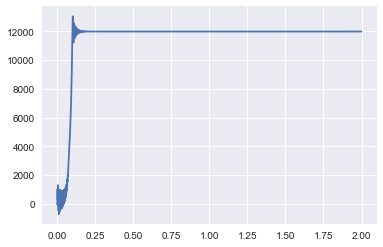

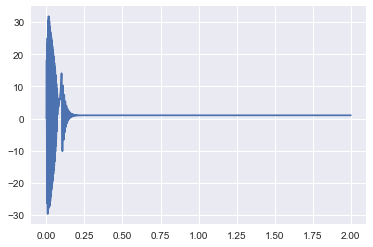

[1.6, 1.65, 30, -30]

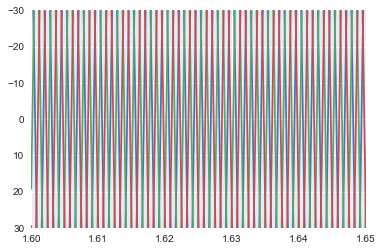

In [5]:
speed= np.dot(60/(4*np.pi) ,speed)
plt.plot(t,speed)
plt.show()
plt.plot(t,torque)
plt.show()

plt.plot(t,i_as)
plt.plot(t,i_bs)
plt.plot(t,i_cs)
plt.axis([1.6,1.65,30,-30])